## Goodreads Book Recommender

#### Introduction

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export page](https://www.goodreads.com/review/import) on your Goodreads profile, download your books, and save as ```./data/goodreads_library_export.csv``` 

#### Contents

[Part 0: Preprocessing](#part-0-preprocessing)
- [0.1 - Load and Prepare Data](#01---load-and-prepare-data)
- [0.1 - Write Functions to Process Recommendations](#02---write-functions-to-process-recommendations)

[Part 1: Collaborative Filtering Based on Reader Similarity with KNN](#part-1---collaborative-filtering-based-on-reader-similarity-with-knn)
- [1.1 - Find Similar Readers](#11---find-similar-readers)
- [1.2 - Generate Recommendations](#12---generate-recommendations)


[Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization](#part-2---collaborative-filtering-based-on-predicted-ratings-with-matrix-factorization)
- [2.1 - Factorize User-Rating Matrix with SVD](#21---factorize-user-rating-matrix-with-svd)
- [2.2 - Generate Recommendations by Predicting Ratings](#22---generate-recommendations-by-predicting-ratings)
- [2.3 - Matrix Factorization with Gradient Descent](#23-matrix-factorization-with-gradient-descent)

## Part 0: Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [2]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres, how="left", on="book_id")

# Filter out kids books
df_books = df_books[df_books.loc[:,"children":"comic"].sum(axis=1) < 2]

In [3]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [4]:
# Create df_reviews that is less sparse than original
in_df_books = book_index["book_id"].isin(df_books["book_id"])
book_index = book_index[in_df_books].reset_index().drop("index", axis=1)
df_reviews = df_reviews[:, in_df_books]

In [5]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# Reformat to fit sparse matrix
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="left", on="book_id", suffixes=["_mb","_dfb"]
            )
my_books_id_match = my_books_1[~my_books_1["title_dfb"].isna()]
print(f"Matching on book_id: {my_books_id_match.shape[0]}")

my_books_2 = pd.merge(
    my_books_1[my_books_1["title_dfb"].isna()], df_books[["book_id", "title"]], 
    how="left", left_on="title_mb", right_on="title", suffixes=["_mb","_dfb"]
    )
my_books_match_on_title = my_books_2[~my_books_2["title"].isna()]
print(f"Matching on title: {my_books_match_on_title.shape[0]}")

my_books_id_match = my_books_id_match[["book_id", "rating", "title_dfb"]]\
                        .rename(columns={"title_dfb":"title"})
my_books_match_on_title = my_books_match_on_title[["book_id_dfb", "rating", "title"]]\
                        .rename(columns={"book_id_dfb":"book_id"})

my_books_3 = pd.concat([my_books_id_match, my_books_match_on_title])
my_books_3 = my_books_3.drop_duplicates(subset="book_id")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csr_matrix(df_reviews)

# Normalize reviews within readers for KNN
norm = Normalizer()
df_reviews_norm = norm.fit_transform(df_reviews) 

Target reader ratings: 168
Matching on book_id: 28
Matching on title: 68
Total matches: 96, 57.14% of total


In [6]:
# # Create df_reviews that is less sparse than original
# in_df_books = book_index["book_id"].isin(df_books["book_id"])
# book_index_dense = book_index[in_df_books].reset_index().drop("index", axis=1)
# df_reviews_dense = df_reviews[:, in_df_books]
# df_reviews_dense_norm = norm.fit_transform(df_reviews_dense)

In [7]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [8]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([2-9]|[1-9]\d+)"
    regex2 = r"Vol. ([0-9]|[1-9]\d+)"
    regex3 = r"Volume ([0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [9]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=400, n_recs=15, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [10]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [11]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):

    # Get genre rankings for target and neighbors
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})
    target_genre_ranking = target_genre_ranking.div(target_genre_ranking.sum(axis=0), axis=1)

    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"neighbor"})
    neighbor_genre_ranking = neighbor_genre_ranking.div(neighbor_genre_ranking.sum(axis=0), axis=1)

    genre_rankings = pd.merge(
            target_genre_ranking, neighbor_genre_ranking, left_index=True, right_index=True
            ).reset_index()

    # Plot target genre pref
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='target',
        s=150,
        edgecolors='black',
        linewidths = 0.75,
        label='Target Reader',
        zorder=2,
        )

    # Plot neighbors genre pref
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='neighbor',
        label='Similar Readers',
        s=150,
        zorder=3
        )

    # Iterate through each genre and plot line connecting 2 points
    for ind in list(genre_rankings['index']):
    
        # Plot line connecting points
        plt.plot([genre_rankings[genre_rankings['index']==ind]['target'],
                    genre_rankings[genre_rankings['index']==ind]['neighbor']],
                    [ind, ind],
                    color='#565A5C',
                    alpha=0.9,                    
                    linestyle=(0, (1,1)),
                    linewidth=2.5,
                    zorder=1
                    )

    # Set chart details
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", borderpad=1)
    ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
    ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
    plt.xlabel("Genre preference")
    plt.ylabel(None)
    plt.title('Top Genres for Target Reader and Similar Readers', fontsize=14)
    plt.show()

## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

### 1.1 - Find Similar Readers

In [12]:
# Perform KNN on user rating matrix
neighbor_user_ratings, target_user_ratings = find_neighbors(75, target, df_reviews_norm, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_25025/1780821165.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_25025/1780821165.py:64: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_25025/1780821165.py:65: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

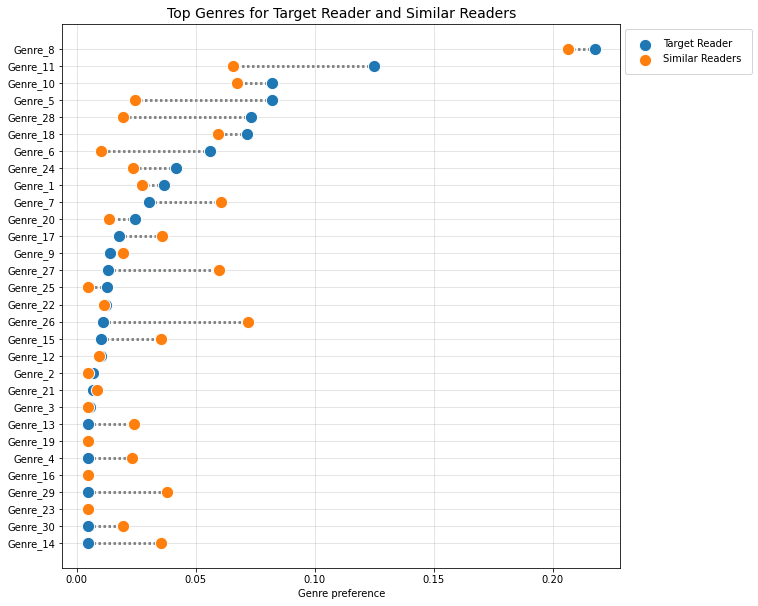

In [13]:
# Show top genres
plot_top_genres(neighbor_user_ratings, target_user_ratings)

In [14]:
# View most popular books among neighbors
neighbors_most_popular(neighbor_user_ratings, 15, min_ratings=400, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
26,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,10.0%,https://www.goodreads.com/book/show/13453029-w...
2,Assata: An Autobiography,4.47,11057.0,1999,5.0%,https://www.goodreads.com/book/show/100322.Assata
25,We Wish to Inform You That Tomorrow We Will Be...,4.29,19564.0,1998,5.0%,https://www.goodreads.com/book/show/11472.We_W...
18,The Brothers Grimm: 101 Fairy Tales,4.20,624.0,2012,5.0%,https://www.goodreads.com/book/show/13584788-t...
23,The Woman on the Orient Express,4.15,2305.0,2016,5.0%,https://www.goodreads.com/book/show/29806077-t...
16,The Bear and the Nightingale (The Winternight ...,4.14,14404.0,2017,5.0%,https://www.goodreads.com/book/show/25489134-t...
9,Genevieve,4.12,4702.0,2006,5.0%,https://www.goodreads.com/book/show/181409.Gen...
5,Clementine: The Life of Mrs. Winston Churchill,4.08,1042.0,2015,5.0%,https://www.goodreads.com/book/show/24611873-c...
11,If We Were a Movie,4.08,1222.0,2016,5.0%,https://www.goodreads.com/book/show/28181098-i...
15,Such a Pretty Fat: One Narcissist's Quest to D...,4.06,24895.0,2008,5.0%,https://www.goodreads.com/book/show/2202049.Su...


In [15]:
# View highest rated books among similar readers
neighbors_top_rated(neighbor_user_ratings, 15, min_ratings=400, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
2,Assata: An Autobiography,4.47,11057.0,1999,https://www.goodreads.com/book/show/100322.Assata
25,We Wish to Inform You That Tomorrow We Will Be...,4.29,19564.0,1998,https://www.goodreads.com/book/show/11472.We_W...
26,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,https://www.goodreads.com/book/show/13453029-w...
18,The Brothers Grimm: 101 Fairy Tales,4.20,624.0,2012,https://www.goodreads.com/book/show/13584788-t...
23,The Woman on the Orient Express,4.15,2305.0,2016,https://www.goodreads.com/book/show/29806077-t...
16,The Bear and the Nightingale (The Winternight ...,4.14,14404.0,2017,https://www.goodreads.com/book/show/25489134-t...
9,Genevieve,4.12,4702.0,2006,https://www.goodreads.com/book/show/181409.Gen...
5,Clementine: The Life of Mrs. Winston Churchill,4.08,1042.0,2015,https://www.goodreads.com/book/show/24611873-c...
11,If We Were a Movie,4.08,1222.0,2016,https://www.goodreads.com/book/show/28181098-i...
15,Such a Pretty Fat: One Narcissist's Quest to D...,4.06,24895.0,2008,https://www.goodreads.com/book/show/2202049.Su...


In [16]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=neighbor_user_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=5, 
    min_score=3.9, 
    min_ratings=400, 
    n_recs=15,
    write_to_excel=False
)

Genre 8: ['people', 'world', 'way', 'question', 'offer', 'guide', 'history', 'science', 'human', 'experience']


,title,avg_rating,ratings_count,url
7,Things No One Will Tell Fat Girls: A Handbook ...,4.06,1488.0,https://www.goodreads.com/book/show/24796533-t...
1,"Bounce: Mozart, Federer, Picasso, Beckham, and...",4.04,3120.0,https://www.goodreads.com/book/show/7845157-bo...
2,Capital in the Twenty-First Century,4.02,13494.0,https://www.goodreads.com/book/show/18736925-c...
6,The Unpersuadables: Adventures with the Enemie...,4.00,580.0,https://www.goodreads.com/book/show/18114379-t...
0,"10% Happier: How I Tamed the Voice in My Head,...",3.93,36749.0,https://www.goodreads.com/book/show/18505796-1...


_____

Genre 11: ['history', 'war', 'century', 'account', 'historical', 'world', 'great', 'year', 'political', 'epic']


,title,avg_rating,ratings_count,url
3,We Wish to Inform You That Tomorrow We Will Be...,4.29,19564.0,https://www.goodreads.com/book/show/11472.We_W...
0,Clementine: The Life of Mrs. Winston Churchill,4.08,1042.0,https://www.goodreads.com/book/show/24611873-c...
2,The Big Sky,4.05,3037.0,https://www.goodreads.com/book/show/202035.The...


_____

Genre 10: ['alien', 'ship', 'planet', 'space', 'crew', 'human', 'world', 'galaxy', 'universe', 'sea']


,title,avg_rating,ratings_count,url
2,Rolling in the Deep (Rolling in the Deep #0.5),3.94,1569.0,https://www.goodreads.com/book/show/23634011-r...


_____

Genre 5: ['collection', 'classic', 'poem', 'fiction', 'text', 'introduction', 'includes', 'art', 'writing', 'short']


,title,avg_rating,ratings_count,url
0,The Brothers Grimm: 101 Fairy Tales,4.2,624.0,https://www.goodreads.com/book/show/13584788-t...


_____

Genre 28: ['family', 'young', 'world', 'year', 'faith', 'black', 'memoir', 'political', 'history', 'journey']


,title,avg_rating,ratings_count,url
0,Assata: An Autobiography,4.47,11057.0,https://www.goodreads.com/book/show/100322.Assata


_____



## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

In sections [2.1](#21---factorize-user-rating-matrix-with-svd) and [2.2](#22---generate-recommendations-by-predicting-ratings) we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$R = U \Sigma \mathbf{V}^\top$$ where $U$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

-----

In section [2.3](#23-matrix-factorization-with-gradient-descent) we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of th math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

#### 2.1 - Factorize User-Rating Matrix with SVD

In [35]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
svd_neighborhood_ratings, target_user_ratings = find_neighbors(
                                                    2500, target, df_reviews_norm, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_25025/1780821165.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_25025/1780821165.py:64: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_25025/1780821165.py:65: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]


In [36]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"\nNeighborhood contains {svd_neighborhood_ratings.shape[0]} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]


Neighborhood contains 24149 books


In [37]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=50)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [38]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(
                all_user_predicted_ratings.toarray(), columns=svd_neighbor_book_index, index=svd_neighbor_index
                ).reset_index()

In [21]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:]

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index", "book_id"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [39]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4.15 & ratings_count > 750").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
110,"Psycho-Cybernetics, A New Way to Get More Livi...",4.21,0.242776,11019.0,1989,https://www.goodreads.com/book/show/155981.Psy...
116,The Birthday of the World and Other Stories,4.27,0.237639,2512.0,2003,https://www.goodreads.com/book/show/68021.The_...
118,How Not to Die: Discover the Foods Scientifica...,4.53,0.235490,4467.0,2015,https://www.goodreads.com/book/show/25663961-h...
133,Country Driving: A Journey Through China from ...,4.19,0.215985,4960.0,2009,https://www.goodreads.com/book/show/6945572-co...
142,Labyrinths: Selected Stories and Other Writings,4.46,0.202773,20553.0,1964,https://www.goodreads.com/book/show/17717.Laby...
168,"I, Robot (Robot, #0.1)",4.17,0.188133,2235.0,2004,https://www.goodreads.com/book/show/76684.I_Robot
170,Well-Read Women: Portraits of Fiction's Most B...,4.30,0.186852,861.0,2013,https://www.goodreads.com/book/show/17557474-w...
173,"Am I Normal Yet? (The Spinster Club, #1)",4.31,0.185207,5252.0,2015,https://www.goodreads.com/book/show/23592235-a...
175,I Feel Sick #1,4.17,0.184541,2104.0,2000,https://www.goodreads.com/book/show/1375054.I_...
189,The Energy of Prayer: How to Deepen Your Spiri...,4.17,0.181818,792.0,2006,https://www.goodreads.com/book/show/95749.The_...


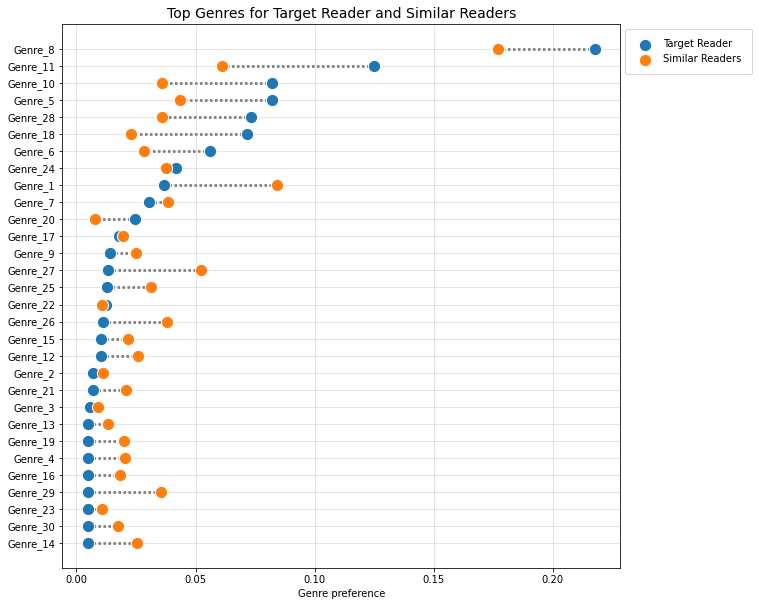

In [23]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [40]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, 50, min_ratings=400, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
584,Bad Feminist,3.91,43988.0,2014,2.2%,https://www.goodreads.com/book/show/18813642-b...
4909,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,2.1%,https://www.goodreads.com/book/show/15819028-t...
5479,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,2002,1.9%,https://www.goodreads.com/book/show/5043.The_P...
6663,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,1.6%,https://www.goodreads.com/book/show/13453029-w...
1322,Doctor Sleep,4.10,98088.0,2013,1.4%,https://www.goodreads.com/book/show/16130549-d...
2979,My Brilliant Friend (The Neapolitan Novels #1),3.89,66369.0,2012,1.3%,https://www.goodreads.com/book/show/13586707-m...
2232,"I, Robot (Robot #0.1)",4.17,201196.0,2004,1.3%,https://www.goodreads.com/book/show/41804.I_Robot
3609,"Rich Dad, Poor Dad",3.96,164543.0,2007,1.3%,https://www.goodreads.com/book/show/69571.Rich...
459,"Angels & Demons (Robert Langdon, #1)",3.86,2046499.0,2006,1.3%,https://www.goodreads.com/book/show/960.Angels...
5020,The Hundred Thousand Kingdoms (Inheritance Tri...,3.81,30194.0,2010,1.2%,https://www.goodreads.com/book/show/6437061-th...


In [41]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, min_ratings=400, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
5094,The Journey Within: A Modern Guide to the Anci...,4.87,971.0,2016,https://www.goodreads.com/book/show/15817111-t...
3312,Patrick O'Brian's Aubrey/Maturin Series,4.83,420.0,2010,https://www.goodreads.com/book/show/8432716-pa...
2266,Ignatius Catholic Study Bible: New Testament,4.78,527.0,2010,https://www.goodreads.com/book/show/6753273-ig...
6005,"The Way of Kings, Part 2 (The Stormlight Archi...",4.78,7803.0,2011,https://www.goodreads.com/book/show/11221285-t...
2795,Mark of the Lion Trilogy,4.76,9189.0,1998,https://www.goodreads.com/book/show/95602.Mark...
5868,The Throne of Glass Coloring Book,4.73,1212.0,2016,https://www.goodreads.com/book/show/28260627-t...
3691,Saga: Book One,4.70,4201.0,2014,https://www.goodreads.com/book/show/22078240-saga
1215,Dear Evan Hansen,4.70,563.0,2017,https://www.goodreads.com/book/show/34381137-d...
3692,Saga: Book Two,4.68,866.0,2017,https://www.goodreads.com/book/show/32926680-saga
2196,I Dissent: Ruth Bader Ginsburg Makes Her Mark,4.67,1665.0,2016,https://www.goodreads.com/book/show/28210996-i...


In [42]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=5, 
    min_score=4.0, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=False
)

Genre 8: ['people', 'world', 'way', 'question', 'offer', 'guide', 'history', 'science', 'human', 'experience']


,title,avg_rating,ratings_count,url
179,Leadership and Self-Deception: Getting out of ...,4.11,730.0,https://www.goodreads.com/book/show/6995673-le...
189,The Energy of Prayer: How to Deepen Your Spiri...,4.17,792.0,https://www.goodreads.com/book/show/95749.The_...
195,Capital in the Twenty-First Century,4.02,13494.0,https://www.goodreads.com/book/show/18736925-c...
196,Hold Me Tight: Seven Conversations for a Lifet...,4.11,3455.0,https://www.goodreads.com/book/show/2153780.Ho...
201,Garbology: Our Dirty Love Affair with Trash,4.05,1148.0,https://www.goodreads.com/book/show/13504054-g...
205,Superforecasting: The Art and Science of Predi...,4.13,4876.0,https://www.goodreads.com/book/show/23995360-s...
215,Unlimited Power : The New Science Of Personal ...,4.21,19373.0,https://www.goodreads.com/book/show/8676.Unlim...
235,When Life Nearly Died: The Greatest Mass Extin...,4.12,708.0,https://www.goodreads.com/book/show/616394.Whe...
246,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
249,Prayer: Does It Make Any Difference?,4.16,4445.0,https://www.goodreads.com/book/show/53827.Prayer


_____

Genre 11: ['history', 'war', 'century', 'account', 'historical', 'world', 'great', 'year', 'political', 'epic']


,title,avg_rating,ratings_count,url
133,Country Driving: A Journey Through China from ...,4.19,4960.0,https://www.goodreads.com/book/show/6945572-co...
138,My Share of the Task: A Memoir,4.10,889.0,https://www.goodreads.com/book/show/13588403-m...
202,American Prometheus: The Triumph and Tragedy o...,4.15,8311.0,https://www.goodreads.com/book/show/80571.Amer...
218,Company K,4.22,470.0,https://www.goodreads.com/book/show/632164.Com...
226,The Whisperers: Private Life in Stalin's Russia,4.16,1573.0,https://www.goodreads.com/book/show/721038.The...
219,Berlin 1961,4.09,968.0,https://www.goodreads.com/book/show/10626601-b...
245,The Bang-Bang Club: Snapshots from a Hidden War,4.20,1469.0,https://www.goodreads.com/book/show/271543.The...
257,The Second World War,4.35,3074.0,https://www.goodreads.com/book/show/13528287-t...
260,"Waterloo: The True Story of Four Days, Three A...",4.19,1904.0,https://www.goodreads.com/book/show/22007249-w...
291,Late Victorian Holocausts: El Niño Famines and...,4.06,811.0,https://www.goodreads.com/book/show/7859.Late_...


_____

Genre 10: ['alien', 'ship', 'planet', 'space', 'crew', 'human', 'world', 'galaxy', 'universe', 'sea']


,title,avg_rating,ratings_count,url
128,Dragon's Egg,4.14,4328.0,https://www.goodreads.com/book/show/263466.Dra...
132,"Master and Commander (Aubrey & Maturin, #1)",4.11,31858.0,https://www.goodreads.com/book/show/77430.Mast...
144,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,609.0,https://www.goodreads.com/book/show/32603222-w...
168,"I, Robot (Robot, #0.1)",4.17,2235.0,https://www.goodreads.com/book/show/76684.I_Robot
284,Heir to the Empire (Star Wars: The Thrawn Tril...,4.12,51211.0,https://www.goodreads.com/book/show/216443.Hei...
308,Schrödinger's Cat Trilogy,4.07,3983.0,https://www.goodreads.com/book/show/62567.Schr...
339,The Mote in God's Eye (Moties #1),4.06,1337.0,https://www.goodreads.com/book/show/11343467-t...
441,The Deep: The Extraordinary Creatures of the A...,4.28,901.0,https://www.goodreads.com/book/show/442668.The...
444,Miracle in the Andes,4.22,11354.0,https://www.goodreads.com/book/show/454236.Mir...
566,"Binti (Binti, #1)",4.02,553.0,https://www.goodreads.com/book/show/25819514-b...


_____

Genre 5: ['collection', 'classic', 'poem', 'fiction', 'text', 'introduction', 'includes', 'art', 'writing', 'short']


,title,avg_rating,ratings_count,url
116,The Birthday of the World and Other Stories,4.27,2512.0,https://www.goodreads.com/book/show/68021.The_...
121,How the Marquis Got His Coat Back,4.12,2718.0,https://www.goodreads.com/book/show/26699591-h...
142,Labyrinths: Selected Stories and Other Writings,4.46,20553.0,https://www.goodreads.com/book/show/17717.Laby...
152,Five Seasons: A Baseball Companion,4.33,474.0,https://www.goodreads.com/book/show/313298.Fiv...
170,Well-Read Women: Portraits of Fiction's Most B...,4.30,861.0,https://www.goodreads.com/book/show/17557474-w...
175,I Feel Sick #1,4.17,2104.0,https://www.goodreads.com/book/show/1375054.I_...
301,Hellblazer: Original Sins,4.11,13173.0,https://www.goodreads.com/book/show/133017.Hel...
303,The Overcoat and Other Tales of Good and Evil,4.26,1281.0,https://www.goodreads.com/book/show/537072.The...
299,Collected Stories,4.18,5756.0,https://www.goodreads.com/book/show/759.Collec...
298,The Manuscript Found in Saragossa,4.17,1398.0,https://www.goodreads.com/book/show/93180.The_...


_____

Genre 28: ['family', 'young', 'world', 'year', 'faith', 'black', 'memoir', 'political', 'history', 'journey']


,title,avg_rating,ratings_count,url
200,Bitch Planet #1,4.18,3120.0,https://www.goodreads.com/book/show/23609469-b...
217,Talking To My Country,4.37,734.0,https://www.goodreads.com/book/show/27429427-t...
262,The Sword of Honour Trilogy,4.26,957.0,https://www.goodreads.com/book/show/30932.The_...
418,Before the Storm: Barry Goldwater and the Unma...,4.19,1852.0,https://www.goodreads.com/book/show/138349.Bef...
483,Tears We Cannot Stop: A Sermon to White America,4.34,2498.0,https://www.goodreads.com/book/show/31421117-t...
521,Dust Tracks on a Road,4.11,4215.0,https://www.goodreads.com/book/show/58399.Dust...
909,Dream Boogie: The Triumph of Sam Cooke,4.01,682.0,https://www.goodreads.com/book/show/99414.Drea...
1131,"Seeking Allah, Finding Jesus: A Devout Muslim ...",4.54,6752.0,https://www.goodreads.com/book/show/18289396-s...
1191,Winter Journey,4.03,892.0,https://www.goodreads.com/book/show/2035785.Wi...
1309,Desert Solitaire,4.22,28380.0,https://www.goodreads.com/book/show/214614.Des...


_____



### 2.3 Matrix Factorization with Gradient Descent

In [27]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
gd_neighborhoodhood_ratings, target_user_ratings = find_neighbors(
                                                        1500, target, df_reviews_norm, book_index, df_books)

# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"\nNeighborhood contains {gd_neighborhood_book_index.shape[0]} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_25025/1780821165.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_25025/1780821165.py:64: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_25025/1780821165.py:65: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]



Neighborhood contains 6289 books


In [28]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=5, steps=4000, lr=0.0002, beta=0.03, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient            

        # Calculate error every n steps                  
        if ((step + 1) % 1000 == 0) | (step == 0): 
            error = 0 # Initialize counter for error  
            error = error + np.sum(pow(resid, 2)) # Add to error
            for k in range(k_components): # for each component (latent feature)                             
                error = error + (beta/2) * np.sum(pow(P[i,k],2) + pow(Q[k,j],2)) # Add regularized term            

            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, error: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 2
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [32]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=50, 
                                    lr=0.009, 
                                    beta=0.07,
                                    decay=True, 
                                    steps=8000, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, error: 74858.00, lr: 0.00900
Step: 1000, error: 4436.06, lr: 0.00450
Step: 2000, error: 4449.74, lr: 0.00225
Step: 3000, error: 4457.04, lr: 0.00112


In [33]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)
top_preds_GD[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4 & ratings_count > 400").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
0,"Spin (Spin, #1)",4.01,7.334107,26520.0,2006,https://www.goodreads.com/book/show/910863.Spin
1,Not a Fan: Becoming a Completely Committed Fol...,4.22,7.316504,23451.0,2011,https://www.goodreads.com/book/show/11198480-n...
5,Atlas of Remote Islands,4.24,6.628503,1807.0,2010,https://www.goodreads.com/book/show/8197735-at...
7,The Women of Brewster Place,4.13,6.390150,14927.0,1983,https://www.goodreads.com/book/show/765811.The...
11,There are No Children Here: The Story of Two B...,4.25,6.224278,10474.0,1991,https://www.goodreads.com/book/show/41918.Ther...
14,"Notes from Underground, White Nights, The Drea...",4.17,6.189571,66680.0,2004,https://www.goodreads.com/book/show/17876.Note...
15,Alive: The Story of the Andes Survivors,4.08,6.185383,50428.0,1975,https://www.goodreads.com/book/show/401514.Alive
17,Muhammad: His Life Based on the Earliest Sources,4.56,6.141951,6837.0,2006,https://www.goodreads.com/book/show/144925.Muh...
18,Sled Driver: Flying the World's Fastest Jet,4.37,6.139070,457.0,1991,https://www.goodreads.com/book/show/1349004.Sl...
19,"Complete Poems, 1904-1962",4.35,6.101824,18787.0,1994,https://www.goodreads.com/book/show/26596.Comp...


In [34]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4.0, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=False
)

Genre 8: ['people', 'world', 'way', 'question', 'offer', 'guide', 'history', 'science', 'human', 'experience']


,title,avg_rating,ratings_count,url
1,Not a Fan: Becoming a Completely Committed Fol...,4.22,23451.0,https://www.goodreads.com/book/show/11198480-n...
31,Every Body Yoga: Let Go of Fear. Get On the Ma...,4.34,619.0,https://www.goodreads.com/book/show/30754069-e...
46,The Roots of Romanticism,4.24,437.0,https://www.goodreads.com/book/show/84713.The_...
59,Tribe: On Homecoming and Belonging,4.04,10078.0,https://www.goodreads.com/book/show/28119237-t...
71,The Journey of Man: A Genetic Odyssey,4.05,937.0,https://www.goodreads.com/book/show/59028.The_...
84,Leaders Eat Last,4.12,9080.0,https://www.goodreads.com/book/show/16144853-l...
87,When Life Nearly Died: The Greatest Mass Extin...,4.12,708.0,https://www.goodreads.com/book/show/616394.Whe...
89,"Surely You're Joking, Mr. Feynman!",4.29,1352.0,https://www.goodreads.com/book/show/17364.Sure...
105,Prisoners of Geography: Ten Maps That Explain ...,4.25,984.0,https://www.goodreads.com/book/show/29430757-p...
110,Brain Rules for Baby: How to Raise a Smart and...,4.25,4671.0,https://www.goodreads.com/book/show/8445273-br...


_____

Genre 11: ['history', 'war', 'century', 'account', 'historical', 'world', 'great', 'year', 'political', 'epic']


,title,avg_rating,ratings_count,url
21,My Share of the Task: A Memoir,4.10,889.0,https://www.goodreads.com/book/show/13588403-m...
154,The Portable Faulkner,4.31,685.0,https://www.goodreads.com/book/show/18790.The_...
161,Cool Gray City of Love: 49 Views of San Francisco,4.22,848.0,https://www.goodreads.com/book/show/16059425-c...
252,House of Glass,4.29,1563.0,https://www.goodreads.com/book/show/174442.Hou...
289,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
295,The Dead and Those About to Die: D-Day: The Bi...,4.09,581.0,https://www.goodreads.com/book/show/18667952-t...
379,The Revolt of the Masses,4.06,1849.0,https://www.goodreads.com/book/show/282447.The...
428,Slouching Towards Bethlehem,4.23,18540.0,https://www.goodreads.com/book/show/424.Slouch...
458,The Last Week: What the Gospels Really Teach A...,4.17,1170.0,https://www.goodreads.com/book/show/103340.The...
538,Sam Walton: Made In America,4.08,9761.0,https://www.goodreads.com/book/show/10631.Sam_...


_____

Genre 10: ['alien', 'ship', 'planet', 'space', 'crew', 'human', 'world', 'galaxy', 'universe', 'sea']


,title,avg_rating,ratings_count,url
5,Atlas of Remote Islands,4.24,1807.0,https://www.goodreads.com/book/show/8197735-at...
15,Alive: The Story of the Andes Survivors,4.08,50428.0,https://www.goodreads.com/book/show/401514.Alive
40,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
52,"Rosie Revere, Engineer",4.54,4789.0,https://www.goodreads.com/book/show/17290220-r...
334,Enemy Mine,4.14,675.0,https://www.goodreads.com/book/show/1534509.En...
353,The Tartar Steppe,4.13,5025.0,https://www.goodreads.com/book/show/83017.The_...
552,The Deep: The Extraordinary Creatures of the A...,4.28,901.0,https://www.goodreads.com/book/show/442668.The...
867,"Deep: Freediving, Renegade Science, and What t...",4.40,1144.0,https://www.goodreads.com/book/show/18222705-deep
875,"Until Midnight (Alienated, #1.5)",4.05,1771.0,https://www.goodreads.com/book/show/22614886-u...
962,The Interstellar Age: Inside the Forty-Year Vo...,4.03,405.0,https://www.goodreads.com/book/show/22571516-t...


_____

Genre 5: ['collection', 'classic', 'poem', 'fiction', 'text', 'introduction', 'includes', 'art', 'writing', 'short']


,title,avg_rating,ratings_count,url
17,Muhammad: His Life Based on the Earliest Sources,4.56,6837.0,https://www.goodreads.com/book/show/144925.Muh...
19,"Complete Poems, 1904-1962",4.35,18787.0,https://www.goodreads.com/book/show/26596.Comp...
32,Van Gogh: The Life,4.09,14046.0,https://www.goodreads.com/book/show/10677213-v...
60,Labyrinths: Selected Stories and Other Writings,4.46,20553.0,https://www.goodreads.com/book/show/17717.Laby...
103,Here Is New York,4.29,4301.0,https://www.goodreads.com/book/show/10814.Here...
156,The Bridge,4.15,693.0,https://www.goodreads.com/book/show/75495.The_...
180,Run With the Hunted: A Charles Bukowski Reader,4.26,3361.0,https://www.goodreads.com/book/show/50452.Run_...
221,A Supposedly Fun Thing I'll Never Do Again: E...,4.28,23746.0,https://www.goodreads.com/book/show/6748.A_Sup...
254,The Private Eye,4.24,1847.0,https://www.goodreads.com/book/show/26247784-t...
274,Lost in Translation: An Illustrated Compendium...,4.24,1336.0,https://www.goodreads.com/book/show/20176282-l...


_____

Genre 28: ['family', 'young', 'world', 'year', 'faith', 'black', 'memoir', 'political', 'history', 'journey']


,title,avg_rating,ratings_count,url
11,There are No Children Here: The Story of Two B...,4.25,10474.0,https://www.goodreads.com/book/show/41918.Ther...
130,The Optician of Lampedusa,4.20,554.0,https://www.goodreads.com/book/show/30807858-t...
219,The Seven Storey Mountain,4.16,9372.0,https://www.goodreads.com/book/show/175078.The...
275,Dream Boogie: The Triumph of Sam Cooke,4.01,682.0,https://www.goodreads.com/book/show/99414.Drea...
347,The Story of Jane: The Legendary Underground F...,4.12,693.0,https://www.goodreads.com/book/show/676543.The...
366,Rest in Power: The Enduring Life of Trayvon Ma...,4.38,463.0,https://www.goodreads.com/book/show/31227733-r...
396,"The Power of One (The Power of One, #1)",4.34,58836.0,https://www.goodreads.com/book/show/122.The_Po...
527,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
672,Agaat,4.05,868.0,https://www.goodreads.com/book/show/7105495-agaat
689,"Reading with Patrick: A Teacher, a Student, an...",4.15,907.0,https://www.goodreads.com/book/show/30900796-r...


_____

Genre 18: ['world', 'zombie', 'human', 'survivor', 'virus', 'city', 'plague', 'humanity', 'survive', 'war']


,title,avg_rating,ratings_count,url
30,There Will Come Soft Rains,4.23,2554.0,https://www.goodreads.com/book/show/2260460.Th...
41,"Indonesia, Etc.: Exploring the Improbable Nation",4.18,470.0,https://www.goodreads.com/book/show/18377963-i...
187,Intentional Dissonance,4.09,571.0,https://www.goodreads.com/book/show/16153306-i...
549,On Palestine,4.10,430.0,https://www.goodreads.com/book/show/23129811-o...
649,Foundation / Foundation and Empire / Second Fo...,4.35,3316.0,https://www.goodreads.com/book/show/278097.Fou...
804,The Hyperion Omnibus: Hyperion / The Fall of H...,4.41,2254.0,https://www.goodreads.com/book/show/3943.The_H...
1129,"This Savage Song (Monsters of Verity, #1)",4.14,2409.0,https://www.goodreads.com/book/show/26074170-t...
1418,"The Walking Dead, Compendium 1",4.43,58434.0,https://www.goodreads.com/book/show/6465707-th...
1882,The Last Rhinos: My Battle to Save One of the ...,4.34,1094.0,https://www.goodreads.com/book/show/13167157-t...
2475,Sandkings,4.24,2846.0,https://www.goodreads.com/book/show/769902.San...


_____

Genre 6: ['agent', 'mission', 'team', 'secret', 'terrorist', 'world', 'dangerous', 'enemy', 'government', 'spy']


,title,avg_rating,ratings_count,url
114,"The Hunter (Victor the Assassin, #1)",4.13,2718.0,https://www.goodreads.com/book/show/10287666-t...
243,The Cartel,4.29,9961.0,https://www.goodreads.com/book/show/23602561-t...
427,Never Split the Difference: Negotiating As If ...,4.49,3314.0,https://www.goodreads.com/book/show/26156469-n...
455,"American Tabloid (Underworld USA, #1)",4.21,10342.0,https://www.goodreads.com/book/show/36064.Amer...
705,Top Dog: The Story of Marine Hero Lucca,4.34,505.0,https://www.goodreads.com/book/show/20893379-t...
977,How to Fight Presidents: Defending Yourself Ag...,4.12,1391.0,https://www.goodreads.com/book/show/17857647-h...
1021,Harrison Bergeron,4.23,10690.0,https://www.goodreads.com/book/show/10176119-h...
1066,"First to Kill (Nathan McBride, #1)",4.04,1897.0,https://www.goodreads.com/book/show/3931026-fi...
1258,The Operator: Firing the Shots that Killed Osa...,4.42,833.0,https://www.goodreads.com/book/show/34127824-t...
1456,Convict Conditioning: How to Bust Free of All ...,4.13,1419.0,https://www.goodreads.com/book/show/7305111-co...


_____

Genre 24: ['world', 'power', 'war', 'enemy', 'battle', 'magic', 'dragon', 'land', 'kingdom', 'warrior']


,title,avg_rating,ratings_count,url
61,Blackwing (Ravens' Mark #1),4.24,401.0,https://www.goodreads.com/book/show/33916060-b...
109,Lost Boy: The True Story of Captain Hook,4.20,1420.0,https://www.goodreads.com/book/show/32828538-l...
147,"The Potato Factory (The Potato Factory, #1)",4.07,6773.0,https://www.goodreads.com/book/show/137808.The...
238,Dawn (Legend of the Galactic Heroes #1),4.06,418.0,https://www.goodreads.com/book/show/25986983-dawn
258,The Beast's Garden,4.03,822.0,https://www.goodreads.com/book/show/23702432-t...
290,"Dancer's Lament (Path to Ascendancy, #1)",4.45,1085.0,https://www.goodreads.com/book/show/25480364-d...
336,When Christ and His Saints Slept (Henry II an...,4.27,10892.0,https://www.goodreads.com/book/show/43841.When...
401,The Shadow of What Was Lost (The Licanius Tril...,4.16,6120.0,https://www.goodreads.com/book/show/22878967-t...
417,"Morrighan (The Remnant Chronicles, #0.5)",4.08,1495.0,https://www.goodreads.com/book/show/28260188-m...
489,Cleopatra's Moon,4.02,3254.0,https://www.goodreads.com/book/show/8465337-cl...


_____

Genre 1: ['family', 'world', 'young', 'time', 'year', 'voice', 'collection', 'child', 'human', 'moving']


,title,avg_rating,ratings_count,url
7,The Women of Brewster Place,4.13,14927.0,https://www.goodreads.com/book/show/765811.The...
14,"Notes from Underground, White Nights, The Drea...",4.17,66680.0,https://www.goodreads.com/book/show/17876.Note...
24,The Course of Love,4.01,7488.0,https://www.goodreads.com/book/show/27845690-t...
29,The Shining / Salems Lot / Night Shift / Carrie,4.64,1400.0,https://www.goodreads.com/book/show/5416.The_S...
34,How to Be Compassionate: a Handbook for Creati...,4.11,416.0,https://www.goodreads.com/book/show/10793510-h...
38,This is the Story of a Happy Marriage,4.03,13538.0,https://www.goodreads.com/book/show/17349222-t...
47,The Peregrine,4.18,1040.0,https://www.goodreads.com/book/show/1071726.Th...
104,Felicity,4.27,2390.0,https://www.goodreads.com/book/show/24611522-f...
164,The Orthodox Heretic And Other Impossible Tales,4.18,899.0,https://www.goodreads.com/book/show/4956232-th...
177,Dear Evan Hansen,4.70,563.0,https://www.goodreads.com/book/show/34381137-d...


_____

Genre 7: ['music', 'film', 'movie', 'star', 'rock', 'band', 'fan', 'actor', 'television', 'career']


,title,avg_rating,ratings_count,url
33,Peter and Alice,4.44,561.0,https://www.goodreads.com/book/show/17347724-p...
99,Come As You Are: The Story of Nirvana,4.03,6859.0,https://www.goodreads.com/book/show/104961.Com...
352,Digging Up Mother: A Love Story,4.30,882.0,https://www.goodreads.com/book/show/28589336-d...
384,Moscow to the End of the Line,4.05,4673.0,https://www.goodreads.com/book/show/117896.Mos...
422,"The ‘If You Prefer a Milder Comedian, Please A...",4.35,468.0,https://www.goodreads.com/book/show/13236798-t...
437,A Work in Progress,4.35,14878.0,https://www.goodreads.com/book/show/22886113-a...
441,Out on the Wire: Uncovering the Secrets of Rad...,4.19,627.0,https://www.goodreads.com/book/show/23742836-o...
513,Dan and Phil Go Outside,4.59,2229.0,https://www.goodreads.com/book/show/30613790-d...
589,Before Sunrise & Before Sunset: Two Screenplays,4.35,1204.0,https://www.goodreads.com/book/show/379119.Bef...
641,The Mayor of MacDougal Street,4.05,813.0,https://www.goodreads.com/book/show/896855.The...


_____

